In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

In [2]:
male = male = sc.read_h5ad("cleaned_data/male_gonadal.h5ad")
female = sc.read_h5ad("cleaned_data/female_gonadal.h5ad")

In [3]:
def get_array(adata: sc.AnnData):
    sorted_genes = sorted(adata.var_names)
    df = pd.DataFrame(adata.X.toarray(), index=adata.obs_names, columns=sorted_genes)
    df2 = adata.obs['cell_type']
    df.sort_index(inplace=True)
    df2.sort_index(inplace=True)

    X = df.to_numpy()
    y = df2.to_numpy()
    return X, y, sorted_genes

In [4]:
male_X, male_y, sorted_genes = get_array(male)
female_X, female_y, _ = get_array(female)

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(male_y)

male_y = le.transform(male_y)
female_y = le.transform(female_y)

In [6]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)
ohe.fit(male_y.reshape(-1, 1))

male_y_onehot = ohe.transform(male_y.reshape(-1, 1))
female_y_onehot = ohe.transform(female_y.reshape(-1, 1))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(male_X, male_y, test_size=0.2, random_state=42, stratify=male_y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((19701, 23333), (4926, 23333), (6157, 23333), (19701,), (4926,), (6157,))

In [8]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

def balanced_sc_resample(X, y, target_count=2000, k_neighbors=5):
    """
    Memory-optimized class balancing for scRNA-seq data with cluster-aware sampling
    Maintains original data dtype and avoids unnecessary copies
    """
    original_y_shape = y.shape
    if y.ndim == 2:
        n_classes = y.shape[1]
        y_labels = np.argmax(y, axis=1)  # Convert to 1D class indices
    else:
        y_labels = y.copy()

    unique_classes, counts = np.unique(y_labels, return_counts=True)
    X_resampled = []
    y_resampled = []
    
    for cls, count in zip(unique_classes, counts):
        cls_mask = (y_labels == cls)
        X_cls = X[cls_mask]
        
        # Cluster-based undersampling for large classes
        if count > target_count:
            # Prototype selection with batch processing
            n_clusters = max(1, target_count // 100)
            kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_cls)
            
            # Find closest real cells to centroids
            centroids = kmeans.cluster_centers_
            dist_chunks = [cdist(X_cls[i::10], centroids) for i in range(10)]
            closest_idx = np.argmin(np.vstack(dist_chunks), axis=0)
            selected = X_cls[closest_idx]
            
            # Memory-efficient sampling
            select_idx = np.random.choice(
                selected.shape[0],
                target_count,
                replace=selected.shape[0] < target_count
            )
            X_resampled.append(selected[select_idx])
            
        # Vectorized oversampling for small classes
        else:
            n_neighbors = min(k_neighbors, count-1) if count > 1 else 0
            n_synthetic = target_count - count
            
            if n_neighbors > 0:
                # Generate all synthetic samples in one batch
                neighbor_idx = np.random.choice(
                    count,
                    size=(n_synthetic, n_neighbors+1),
                    replace=True  # Allow reuse for small populations
                )
                weights = np.random.dirichlet(np.ones(n_neighbors+1), n_synthetic)
                synthetic = np.einsum('ij,ijk->ik', weights, X_cls[neighbor_idx])
            else:
                # Handle single-cell case with duplication
                synthetic = np.tile(X_cls, (n_synthetic, 1))
            
            X_resampled.append(np.vstack([X_cls, synthetic]))
        
        y_resampled.append(np.full(target_count, cls))

    y_balanced = np.concatenate(y_resampled)
    if len(original_y_shape) == 2:
        # Recreate one-hot encoding with original class dimensions
        y_balanced = np.eye(n_classes)[y_balanced.astype(int)]
    
    return np.vstack(X_resampled), y_balanced

In [9]:
X_train_resampled, y_train_resampled = balanced_sc_resample(X_train, y_train, target_count=4000, k_neighbors=5)
X_train_resampled.shape, y_train_resampled.shape

c:\Users\venka\miniconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=23.
  warnings.warn(


((32000, 23333), (32000,))

In [10]:
# Shuffle the data
from sklearn.utils import shuffle

X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled)

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import scipy.special

from collections import Counter

In [12]:
sgd_clf = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train_resampled, y_train_resampled)

SGDClassifier(loss='log_loss', random_state=42)

In [13]:
y_pred = sgd_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_test, y_pred, target_names=[le.classes_[int(s.split('_')[1])] for s in ohe.get_feature_names_out()], zero_division=0))

Accuracy: 0.5871
F1 Score: 0.6224
                       precision    recall  f1-score   support

     endothelial cell       0.43      1.00      0.60       167
      epithelial cell       0.84      0.69      0.75      1766
          erythrocyte       0.07      1.00      0.13        72
            germ cell       1.00      0.99      1.00       167
     mesenchymal cell       1.00      0.37      0.53      3128
          neural cell       0.80      1.00      0.89       260
skeletal muscle fiber       0.24      0.99      0.39       124
      supporting cell       0.41      1.00      0.58       473

             accuracy                           0.59      6157
            macro avg       0.60      0.88      0.61      6157
         weighted avg       0.86      0.59      0.62      6157



In [14]:
y_other_pred = sgd_clf.predict(female_X)

accuracy_other = accuracy_score(female_y, y_other_pred)
f1_other = f1_score(female_y, y_other_pred, average='weighted')

print(f"Accuracy (Female): {accuracy_other:.4f}")
print(f"F1 Score (Female): {f1_other:.4f}")

print(classification_report(female_y, y_other_pred, target_names=[le.classes_[int(s.split('_')[1])] for s in ohe.get_feature_names_out()], zero_division=0))

Accuracy (Female): 0.6071
F1 Score (Female): 0.6192
                       precision    recall  f1-score   support

     endothelial cell       0.73      1.00      0.84      1371
      epithelial cell       0.77      0.80      0.79      5322
          erythrocyte       0.12      0.99      0.21       911
            germ cell       1.00      0.95      0.98      5373
     mesenchymal cell       1.00      0.21      0.34     14074
          neural cell       0.93      0.99      0.96       671
skeletal muscle fiber       0.18      0.99      0.31       834
      supporting cell       0.86      0.88      0.87      4564

             accuracy                           0.61     33120
            macro avg       0.70      0.85      0.66     33120
         weighted avg       0.89      0.61      0.62     33120



In [15]:
import shap

background = shap.sample(X_train_resampled, 1000, random_state=42)
explainer = shap.LinearExplainer(sgd_clf, background)
shap_values = explainer.shap_values(X_test)

In [16]:
shap_values.shape

(6157, 23333, 8)

In [17]:
from Ensembl_converter import EnsemblConverter

# Convert one-hot test labels to integer labels for grouping
y_test_int = y_test
cell_type_marker_shap = {}
cell_type_marker_gene_symbol = {}
converter = EnsemblConverter()

# Loop over each cell type (using le.classes_ for names)
for class_idx, class_name in enumerate(le.classes_):
    indices = np.where(y_test_int == class_idx)[0]
    # For each class, select the corresponding SHAP values and average their absolute values
    class_shap = shap_values[indices, :, class_idx]  # shape [n_samples, num_genes]
    print(f"SHAP values for {class_name}:", class_shap.shape)
    mean_shap = np.mean(np.abs(class_shap), axis=0)
    # Get indices of the top 10 genes (largest average importance)
    top_indices = np.argsort(mean_shap)[-10:][::-1]
    cell_type_marker_shap[class_name] = [sorted_genes[i] for i in top_indices]
    print(f"Top 10 marker genes for {class_name} (via SHAP):", cell_type_marker_shap[class_name])

    # Convert Ensembl IDs to gene symbols
    gene_symbols = converter.convert_ids(cell_type_marker_shap[class_name])
    cell_type_marker_gene_symbol[class_name] = gene_symbols
    print(f"Gene symbols for {class_name}:")
    print(gene_symbols)
    print("\n\n")


SHAP values for endothelial cell: (167, 23333)
Top 10 marker genes for endothelial cell (via SHAP): ['ENSMUSG00000026921', 'ENSMUSG00000034845', 'ENSMUSG00000001240', 'ENSMUSG00000054690', 'ENSMUSG00000016494', 'ENSMUSG00000041378', 'ENSMUSG00000031871', 'ENSMUSG00000032766', 'ENSMUSG00000062960', 'ENSMUSG00000046470']
Gene symbols for endothelial cell:
                 ENSG Symbol
0  ENSMUSG00000026921  Egfl7
1  ENSMUSG00000034845  Plvap
2  ENSMUSG00000001240  Ramp2
3  ENSMUSG00000054690   Emcn
4  ENSMUSG00000016494   Cd34
5  ENSMUSG00000041378  Cldn5
6  ENSMUSG00000031871   Cdh5
7  ENSMUSG00000032766  Gng11
8  ENSMUSG00000062960    Kdr
9  ENSMUSG00000046470  Sox18



SHAP values for epithelial cell: (1766, 23333)
Top 10 marker genes for epithelial cell (via SHAP): ['ENSMUSG00000013584', 'ENSMUSG00000002980', 'ENSMUSG00000023043', 'ENSMUSG00000026728', 'ENSMUSG00000049775', 'ENSMUSG00000027239', 'ENSMUSG00000052957', 'ENSMUSG00000043969', 'ENSMUSG00000029810', 'ENSMUSG00000001506']
Ge

In [18]:
import plotly.graph_objs as go

import plotly.io as pio
pio.renderers.default = "browser"

# symbols = ['circle', 'square', 'diamond', 'star', 'pentagon', 'triangle']
# symbols = ['circle', 'circle-open', 'diamond', 'diamond-open', 'square', 'square-open']
symbols = ['circle', 'diamond', 'square']
symbols_3d = ['circle',  'diamond', 'square']
# colors = ['#fb5607', '#ff006e', '#8338ec', '#3a86ff', '#344e41', 
        #   '#ee6c4d', '#9d0208', '#8ac926', '#a53860', '#27187e']
colors = ['#003049', '#d62828', '#f77f00', '#ff006e', '#8338ec', 
          '#3a86ff', '#008000', '#49111c', '#00cc7a', '#6c3f18']

def plotly_3d_pca_plot(X_pca, y):
    df = pd.DataFrame(data={
        'x': X_pca[:, 0].tolist(),
        'y': X_pca[:, 1].tolist(),
        'z': X_pca[:, 2].tolist(),
        'class': y
    })

    fig = go.Figure(layout = go.Layout(
        paper_bgcolor='rgba(0,0,0,0)'
    ))
    for target in df['class'].unique():
        fig.add_trace(
            go.Scatter3d(
                # x=df[df['class']==target]['x'],
                x=-df[df['class']==target]['x'],
                y=df[df['class']==target]['y'],
                z=df[df['class']==target]['z'],
                mode='markers',
                marker=dict(
                    size=6,   # TODO To change 3D PCA Symbol size
                    symbol=symbols_3d[target % len(symbols_3d)],
                    color=colors[target % len(colors)],
                    opacity=1,
                    showscale=False
                ),
                name=le.classes_[target % len(le.classes_)],
            )
        )
    #  selecting the axis controls
    fig.update_layout(
        scene=dict(
            xaxis=dict(title=dict(text='PC1', font=dict(size=20, color='black')), linecolor='black', ticks='outside', 
                       ticklen=10, tickfont=dict(size=16, color ='black'), linewidth=2, gridcolor='#a68a64'),
            yaxis=dict(title=dict(text='PC2', font=dict(size=20, color='black')), tickangle=0, linecolor='rgb(0, 0, 0)', 
                       ticks='outside', ticklen=10, tickfont=dict(size=16, color ='black'), linewidth=2, 
                       gridcolor='#a68a64'),       
            zaxis=dict(title=dict(text='PC3', font=dict(size=20, color='black')), tickangle=0, linecolor='rgb(0, 0, 0)', 
                       ticks='outside', ticklen=10, tickfont=dict(size=16, color ='black'), 
                       linewidth=2, gridcolor='#a68a64'),       

            # xaxis=dict(showline=True, title='PCA Component 1', tickfont_size=14, title_font_size=16),
            # yaxis=dict(showline=True, title='PCA Component 2', tickfont_size=14, title_font_size=16),
            # zaxis=dict(showline=True, title='PCA Component 3', tickfont_size=14, title_font_size=16),
            bgcolor='white'
        ),
        title='3D PCA Plot',
        plot_bgcolor='rgb(255, 255, 255)',
        paper_bgcolor='rgb(255, 255, 255)',
        width=1000,
        height=1000,
        legend=dict(
            font=dict(size=16),
            itemsizing='constant',
            title='Class',
            bgcolor='rgba(0,0,0,0)'
        )
    )
    
    return fig

def plotly_2d_pca_plot(X_pca, y):
    """
    Plot 2D PCA visualization with consistent styling
    
    Parameters:
    -----------
    X_pca : numpy.ndarray
        The PCA coordinates of shape (n_samples, 2)
    y : numpy.ndarray
        Cell type labels
    """
    df = pd.DataFrame(data={
        'x': X_pca[:, 0].tolist(),
        'y': X_pca[:, 1].tolist(),
        'class': y
    })

    # Create figure with consistent styling
    fig = go.Figure()
    
    # Add traces for each cell type
    for target in sorted(df['class'].unique()):
        mask = df['class'] == target
        fig.add_trace(
            go.Scatter(
                x=df[mask]['x'],
                y=df[mask]['y'],
                mode='markers',
                marker=dict(
                    size=6,
                    symbol=symbols[target % len(symbols)],
                    color=colors[target % len(colors)],
                    opacity=0.9,
                    # line=dict(width=1, color='black'),
                ),
                name=le.classes_[target] if target < len(le.classes_) else f"Type {target}",
            )
        )

    # Update layout with consistent styling
    fig.update_layout(
        title=dict(
            text='2D TSNE Visualization',
            font=dict(size=22)
        ),
        xaxis=dict(
            title=dict(text='t-SNE1', font=dict(size=18)),
            showline=True,
            linecolor='black',
            mirror=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinecolor='lightgrey',
            tickfont=dict(size=14)
        ),
        yaxis=dict(
            title=dict(text='t-SNE2', font=dict(size=18)),
            showline=True,
            linecolor='black',
            mirror=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinecolor='lightgrey',
            tickfont=dict(size=14)
        ),
        width=900,
        height=700,
        plot_bgcolor='white',
        paper_bgcolor='white',
        legend=dict(
            font=dict(size=14),
            bordercolor='black',
            borderwidth=1,
            itemsizing='constant',
            title='Cell Type'
        ),
        margin=dict(l=80, r=80, t=100, b=80)
    )

    return fig


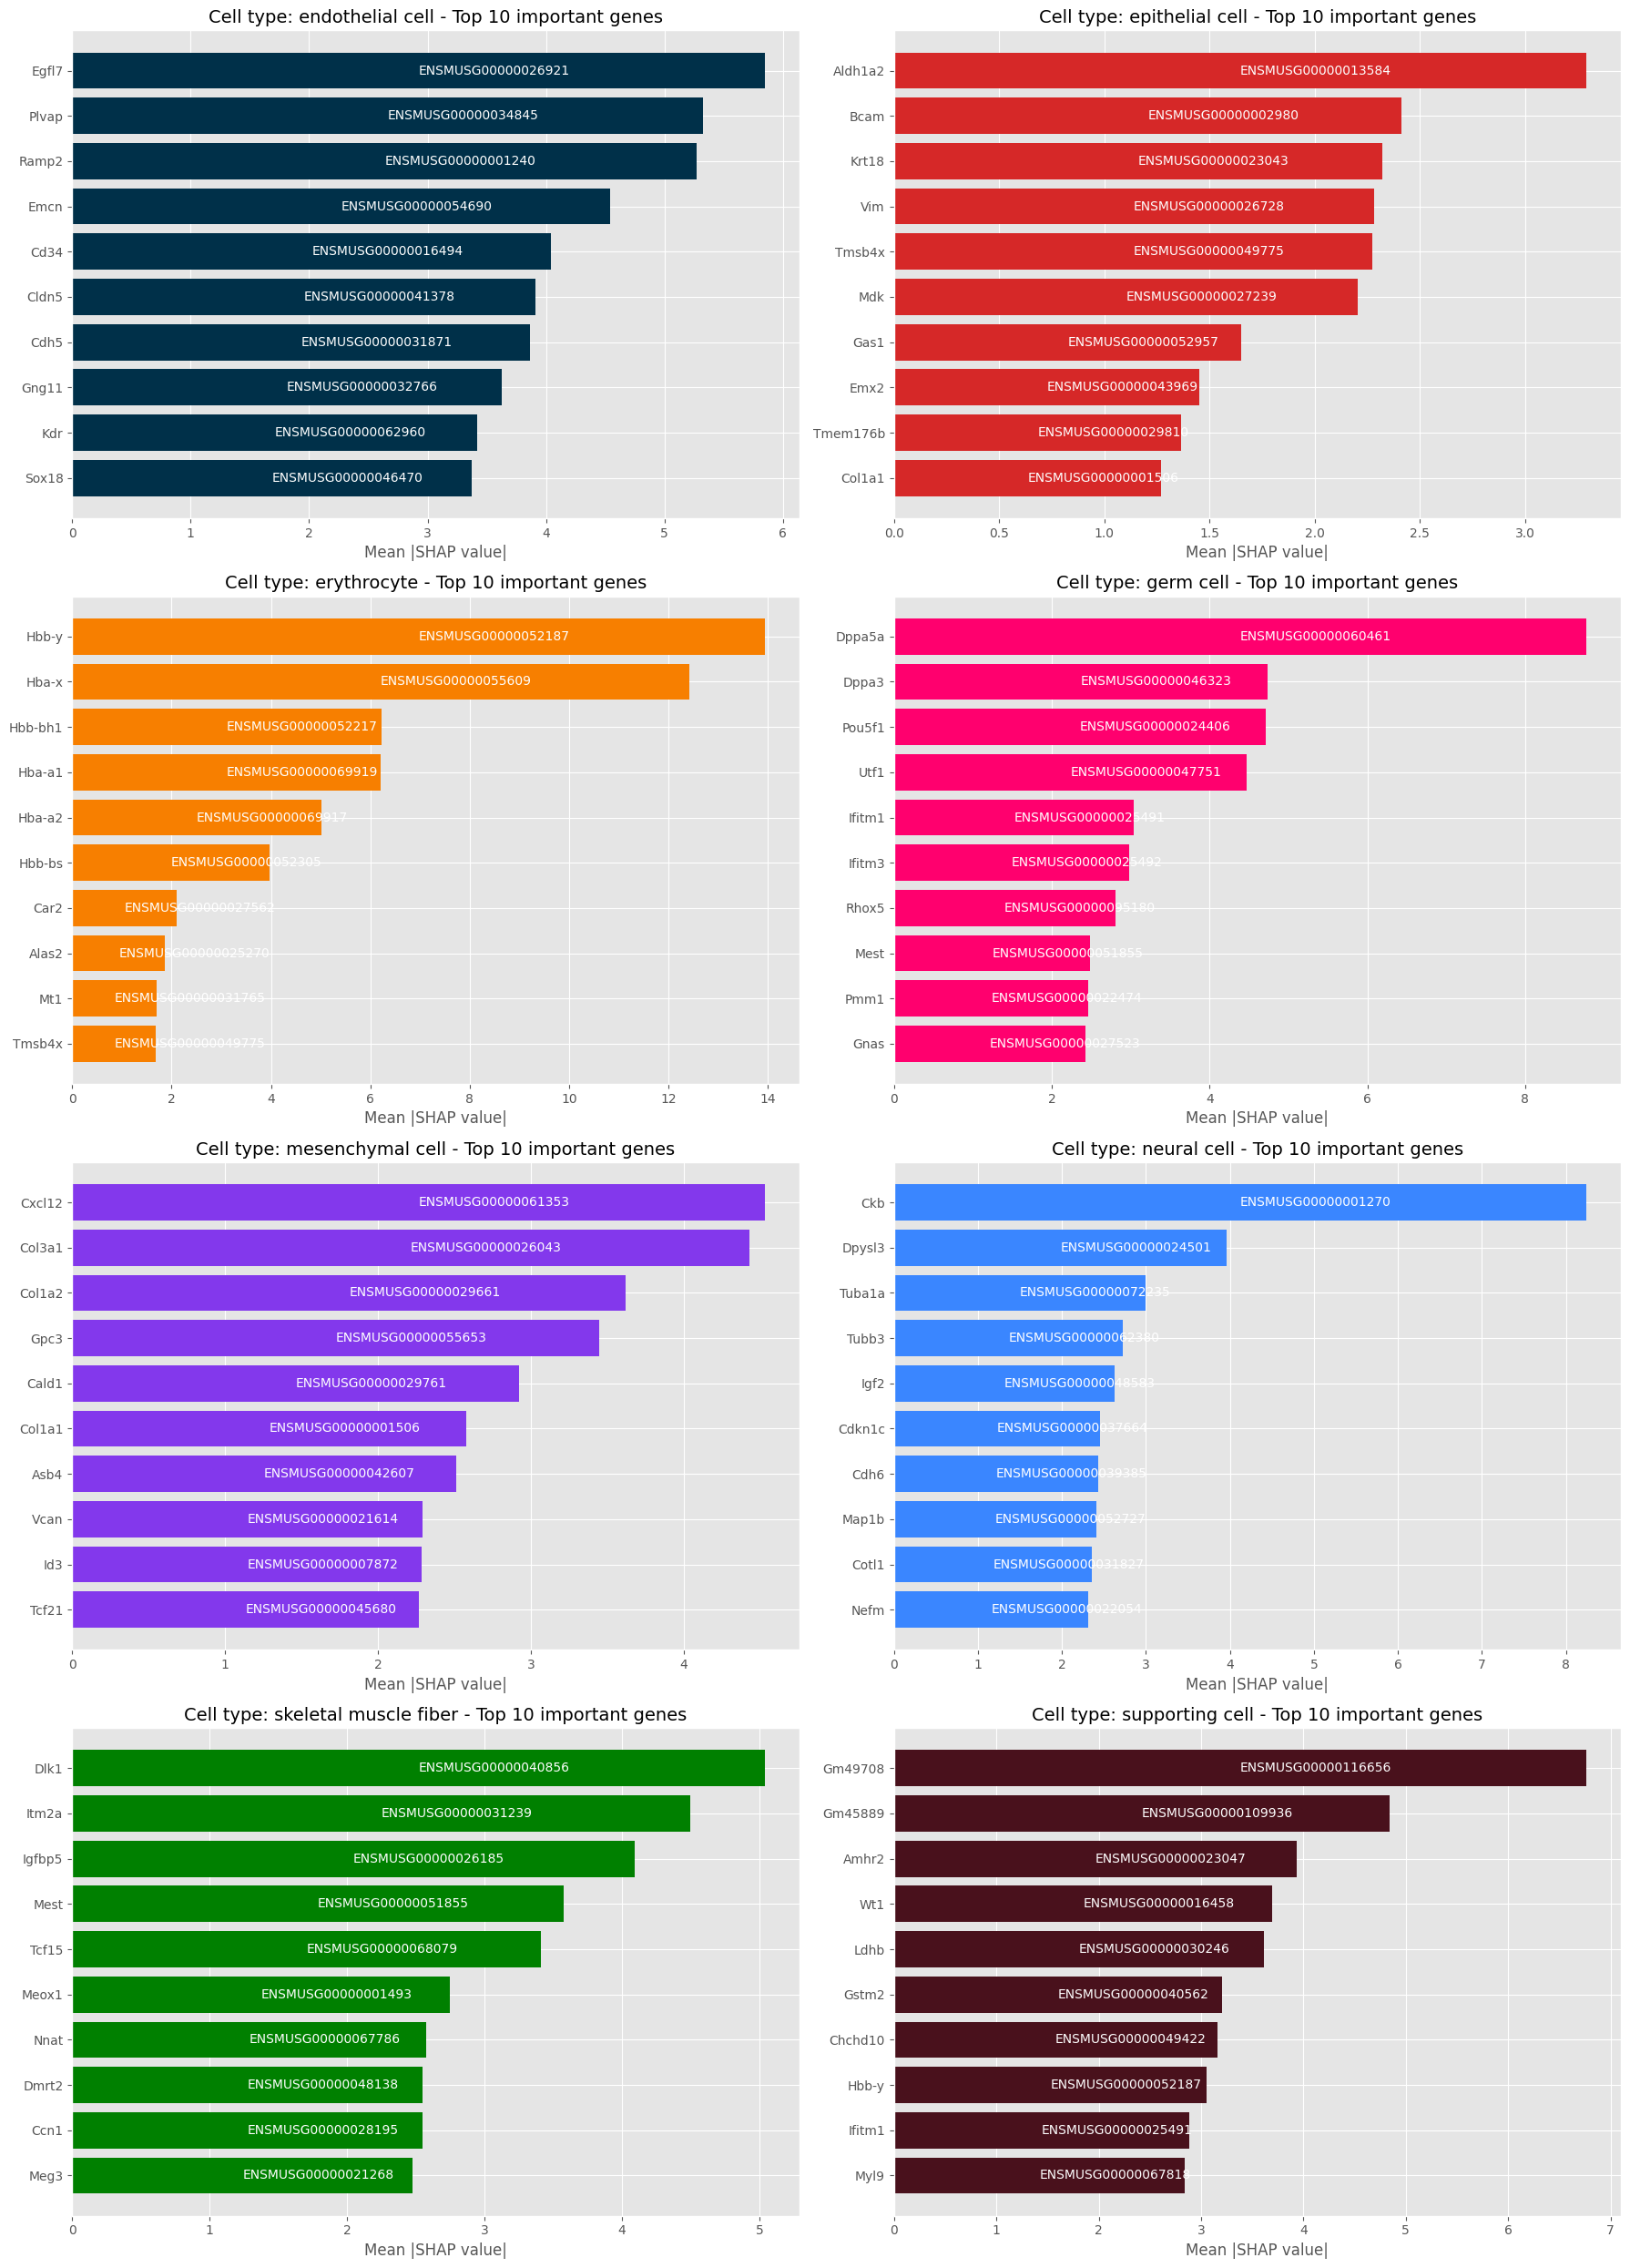

In [19]:
import numpy as np
from Ensembl_converter import EnsemblConverter

import matplotlib.pyplot as plt

# Convert one-hot test labels to integer labels for grouping
y_test_int = y_test
converter = EnsemblConverter()

# Set up the figure size and styling
plt.style.use('ggplot')
plt.figure(figsize=(18, 25))

# Loop over each cell type
for class_idx, class_name in enumerate(le.classes_):
    indices = np.where(y_test_int == class_idx)[0]
    
    # Skip if no samples for this class
    if len(indices) == 0:
        continue
    
    # For each class, select the corresponding SHAP values and average their absolute values
    class_shap = shap_values[indices, :, class_idx]  # shape [n_samples, num_genes]
    mean_shap = np.mean(np.abs(class_shap), axis=0)
    
    # Get indices of the top 10 genes (largest average importance)
    top_indices = np.argsort(mean_shap)[-10:]
    top_genes = [sorted_genes[i] for i in top_indices]
    
    # Convert Ensembl IDs to gene symbols
    gene_info = converter.convert_ids(top_genes)
    gene_symbols = gene_info["Symbol"].values
    
    # Create a subplot for this cell type
    plt.subplot(4, 2, class_idx + 1)
    
    # Create horizontal bar plot
    y_pos = np.arange(len(top_indices))
    plt.barh(y_pos, mean_shap[top_indices], align='center', color=colors[class_idx % len(colors)])
    
    # Set labels and titles
    plt.yticks(y_pos, gene_symbols)
    plt.xlabel('Mean |SHAP value|')
    plt.title(f'Cell type: {class_name} - Top 10 important genes', fontsize=14)
    
    # Add Ensembl IDs as small text
    for i, gene_id in enumerate(top_genes):
        plt.text(mean_shap[top_indices[i]]/2, i, gene_id, 
                 fontsize=10, color='white', va='center', alpha=1)
    
    plt.tight_layout()

plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.savefig("cell_type_markers_shap.png", dpi=300, bbox_inches='tight')
plt.show()